# Arabic Dialects Detection

### Inataling and Importing libraries

In [1]:
#!pip install gensim
#!pip install --upgrade arabic-reshaper

Requirement already up-to-date: arabic-reshaper in c:\users\mlk\anaconda3\lib\site-packages (2.1.3)


In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import gensim


import re
import os
import string
import codecs
import arabic_reshaper
import pyarabic.araby as araby


from bidi.algorithm import get_display

import nltk
from nltk import word_tokenize
from nltk import pos_tag
from nltk.tag import StanfordPOSTagger
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import seaborn as sns


from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 

from collections import defaultdict
from collections import Counter
from tqdm import tqdm

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MLK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MLK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Get max display

In [4]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Importing data in a DataFrame

In [5]:
dialectdf = pd.read_csv('D:/Desktop/final_dialect_dataset.csv', encoding ='utf8',engine = 'python')

### Data exploration

In [6]:
dialectdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458292 entries, 0 to 458291
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458292 non-null  object
 1   dialect  458197 non-null  object
 2   tweet    458197 non-null  object
dtypes: object(3)
memory usage: 10.5+ MB


In [7]:
dialectdf.isnull().sum()

id          0
dialect    95
tweet      95
dtype: int64

In [8]:
dialectdf = dialectdf.dropna()

In [9]:
dialectdf["dialect"].nunique() 

18

In [10]:
dialectdf["dialect"].unique()

array(['IQ', 'LY', 'QA', 'PL', 'SY', 'TN', 'JO', 'MA', 'SA', 'YE', 'DZ',
       'EG', 'LB', 'KW', 'OM', 'SD', 'AE', 'BH'], dtype=object)

In [13]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map 

Text(0, 0.5, 'Dialect size in the data')

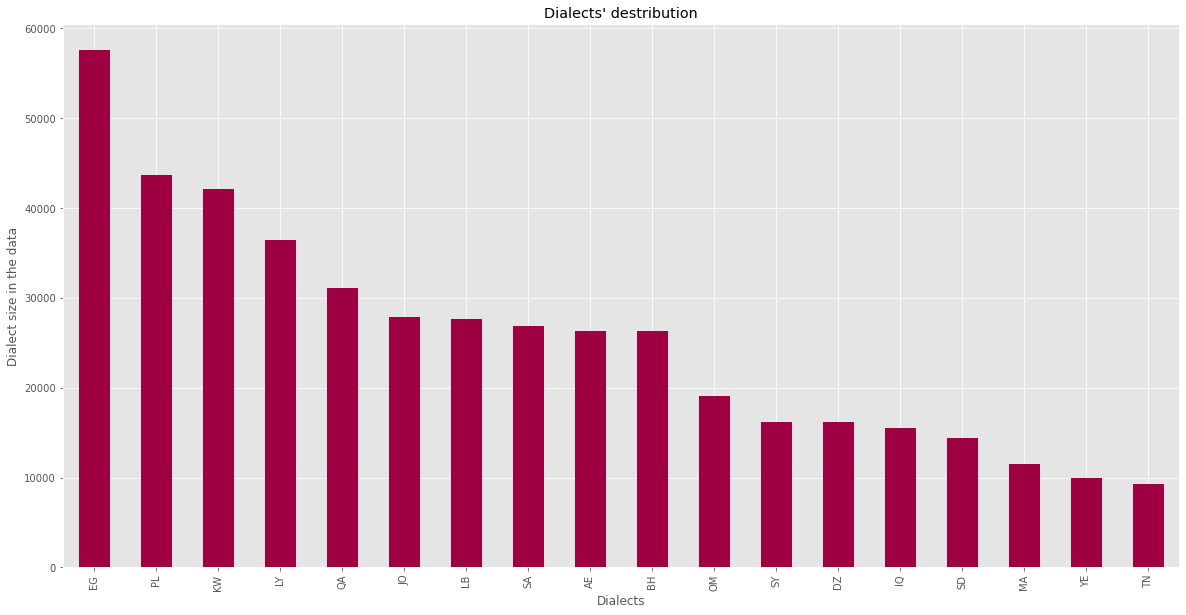

In [24]:
dialectdf["dialect"].value_counts().plot(kind = 'bar', figsize=(20, 10), cmap=cmap, edgecolor='None')
plt.title("Dialects' destribution")
plt.xlabel("Dialects")
plt.ylabel("Dialect size in the data")

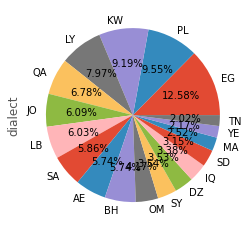

In [16]:
dialectdf['dialect'].value_counts().plot.pie(autopct='%1.2f%%')

## Preprocessing data

##### converting dialects label into lower case

In [25]:
dialectdf['dialect'] = dialectdf['dialect'].str.lower() 

### Normalizing some characters
####  install pyarabic

In [26]:
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('هه','')
    return text.strip()

In [30]:
dialectdf['tweet']= dialectdf['tweet'].apply(normalizeArabic)

In [28]:
dialectdf['tweet'] =  dialectdf['tweet'].apply(lambda x: araby.strip_diacritics(x))

#### Remove longation

In [29]:
dialectdf['clean_text'] = dialectdf['tweet'].apply(lambda x: re.sub(r'(.)\1+', r'\1\1',x))

#### Remove insult words containing *

In [31]:
dialectdf['clean_text']=dialectdf['clean_text'].str.replace('(\*\w+)'," ")

In [34]:
dialectdf.sample(2)

,id,dialect,tweet,clean_text
431489,871528810621149184,ae,حتى لو اني احبك حيل صدقني\nماراح اذرف على الفرقا ولا دمعه .,حتى لو اني احبك حيل صدقني\nماراح اذرف على الفرقا ولا دمعه .
438489,999085542456381440,bh,الشي الوحيد اللي احب ارتبه وبدون ما اتنرفز ​\n- *الفلوس* -\n\nولا احب احد يساعدني بعد 😂😎💰,الشي الوحيد اللي احب ارتبه وبدون ما اتنرفز ​\n- * -\n\nولا احب احد يساعدني بعد 😂😎💰


#### Remove ان شاء الله

In [19]:
#dialectdf['clean_text']=dialectdf['tweet'].str.replace('ان شاء الله'," ")

#### Remove unrelated Characters

In [35]:
def remove_all(text):
    return re.sub('[^چ ھ گ ء-ي ]', ' ', str(text))

In [36]:
dialectdf['clean_tweet'] = dialectdf['clean_text'].apply(remove_all)

#### Remove stop words

In [37]:
stop_words = stopwords.words('arabic')
        

In [41]:
my_stop =  ['أن','أنا','أنت','أنتم','أنه','أهلا','أو','بس','و','إذا','إلى','احد','هم','هو','هي','من','في','على','لما','حتى','انت','او','مع','من','فى','او','ان','انا','انت','انتم','شاء','فى','اهلا','الله','هه']

In [42]:
newstop = stop_words + my_stop

In [43]:

dialectdf['no_stopw']= dialectdf['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (newstop)]))

### filtering columns

In [44]:
dialectdf = dialectdf.drop(columns=['id','tweet','clean_text'], axis=1)

In [45]:
#dialectdf.to_csv('D:/Desktop/clean_dialects_dataset.csv', encoding="utf-8-sig")

## Finding out characters counts and word counts

In [46]:
def char_count(x):
    s = x.split()
    x = ''.join(s)
    return len(x)

dialectdf['char_count'] = dialectdf['clean_tweet'].apply(lambda x: char_count(str(x)))

In [47]:
dialectdf['word_count']= dialectdf['clean_tweet'].apply(lambda x: len(str(x).split()))

In [48]:
dialectdf['nostop_count']= dialectdf['no_stopw'].apply(lambda x: len(str(x).split()))

In [49]:
dialectdf.sample(3)

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count
361373,kw,طبعا عليه كل يوم الصبح يجي يغسل السياره قبل الدوام,طبعا يوم الصبح يجي يغسل السياره الدوام,41,10,7
43983,ly,عندي خليقه كتابات خاصه بالايلتس منهج متكامل وكانت الرغبه فيه لا توصف لكن الوقت صعب نوفق ف قرايته لتو نتفرج عليهم,عندي خليقه كتابات خاصه بالايلتس منهج متكامل وكانت الرغبه توصف الوقت صعب نوفق قرايته لتو نتفرج عليهم,92,21,17
457388,bh,تراقب كلامي و تقرا افكاري و اكيد تدري اني احبك من رمشه عين,تراقب كلامي تقرا افكاري اكيد تدري اني احبك رمشه,46,13,9


In [30]:
#dialectdf.to_csv('D:/Desktop/clean_dialect_dataset_count.csv', encoding="utf-8-sig")

In [50]:
dialectdf['word_count'].max()

88

In [51]:
dialectdf['nostop_count'].max()

61

In [52]:
dialectdf[dialectdf['word_count']==88]

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count
232674,dz,يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا بر يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب يا رب الجزايز السنغال,رب رب رب رب رب رب رب رب رب بر رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب رب الجزايز السنغال,186,88,45


In [53]:
dialectdf[dialectdf['nostop_count']==61]

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count
180337,ma,تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو,تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو تفو,183,61,61


In [54]:
dialectdf['word_count'].min()

0

In [55]:
dialectdf[dialectdf['word_count'] <2].index

Int64Index([  4457,   4458,   5611,  11433,  11434,  14196,  18586,  18608,
             22372,  23903,
            ...
            404246, 404557, 409423, 415620, 422806, 432350, 447327, 451180,
            456886, 457367],
           dtype='int64', length=190)

In [56]:
dialectdf[dialectdf['word_count']==0].index

Int64Index([  4457,   4458,   5611,  11433,  11434,  14196,  18586,  18608,
             22372,  23903,
            ...
            403506, 403622, 404244, 404245, 404246, 404557, 415620, 432350,
            447327, 451180],
           dtype='int64', length=132)

In [58]:
ind0 = dialectdf[dialectdf['word_count']==0].index

In [59]:
dialectdf.drop(index = ind0, inplace = True) #droping empty cells

In [60]:
dialectdf[dialectdf['word_count']==0]

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count


In [61]:
dialectdf['word_count'].min()

1

In [62]:
dialectdf[dialectdf['word_count']==1]

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count
31238,ly,البشريه,البشريه,7,1,1
35881,ly,هناك,,4,1,0
36764,ly,تو,تو,2,1,1
37216,ly,وو,وو,2,1,1
38592,ly,ساعات,ساعات,5,1,1
44642,ly,فيه,,3,1,0
45881,ly,ـ,ـ,1,1,1
45882,ly,الثلب,الثلب,5,1,1
46398,ly,وكا,وكا,3,1,1
67719,qa,ي,,1,1,0


In [64]:
 dialectdf[dialectdf['word_count'] <2].index

Int64Index([ 31238,  35881,  36764,  37216,  38592,  44642,  45881,  45882,
             46398,  67719,  85198, 109164, 109166, 137423, 137426, 137685,
            139493, 147862, 150882, 152935, 164284, 166781, 169528, 170045,
            170139, 175285, 219772, 223851, 223871, 226713, 226745, 226825,
            228942, 236437, 287504, 288157, 297230, 302915, 352223, 372751,
            377316, 380338, 391884, 391931, 391990, 392016, 392042, 392043,
            392046, 393863, 394743, 395494, 403173, 403196, 409423, 422806,
            456886, 457367],
           dtype='int64')

In [66]:
ind1 =  dialectdf[dialectdf['word_count'] <2].index

In [67]:
dialectdf.drop(index = ind1 , inplace = True) #droping empty cells

In [65]:
dialectdf[dialectdf['nostop_count']==1]

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count
188,iq,دووم ان شاء الله,دووم,13,4,1
724,iq,لا راح استثنيك,استثنيك,12,3,1
899,iq,ان شاء الله حتى تصيفي,تصيفي,17,5,1
1112,iq,انا هم نفس الحاله,الحاله,14,4,1
1823,iq,واو غير يستقر ا,يستقر,12,4,1
...,...,...,...,...,...,...
455094,bh,ما هو مصيرنا بعد,مصيرنا,13,4,1
455782,bh,ي د ي س رت ط ق ي د ن,رت,11,10,1
456119,bh,خيره ان شاء الله,خيره,13,4,1
456959,bh,وعليه عليه راح فيها,وعليه,16,4,1


In [49]:
#dialectdf.drop(index = 294402, inplace = True) #droping non-word cell

In [68]:
dialectdf[dialectdf['nostop_count']==1]

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count
188,iq,دووم ان شاء الله,دووم,13,4,1
724,iq,لا راح استثنيك,استثنيك,12,3,1
899,iq,ان شاء الله حتى تصيفي,تصيفي,17,5,1
1112,iq,انا هم نفس الحاله,الحاله,14,4,1
1823,iq,واو غير يستقر ا,يستقر,12,4,1
...,...,...,...,...,...,...
454320,bh,بكره ان شاء الله,بكره,13,4,1
455094,bh,ما هو مصيرنا بعد,مصيرنا,13,4,1
455782,bh,ي د ي س رت ط ق ي د ن,رت,11,10,1
456119,bh,خيره ان شاء الله,خيره,13,4,1


## Exploring most common words

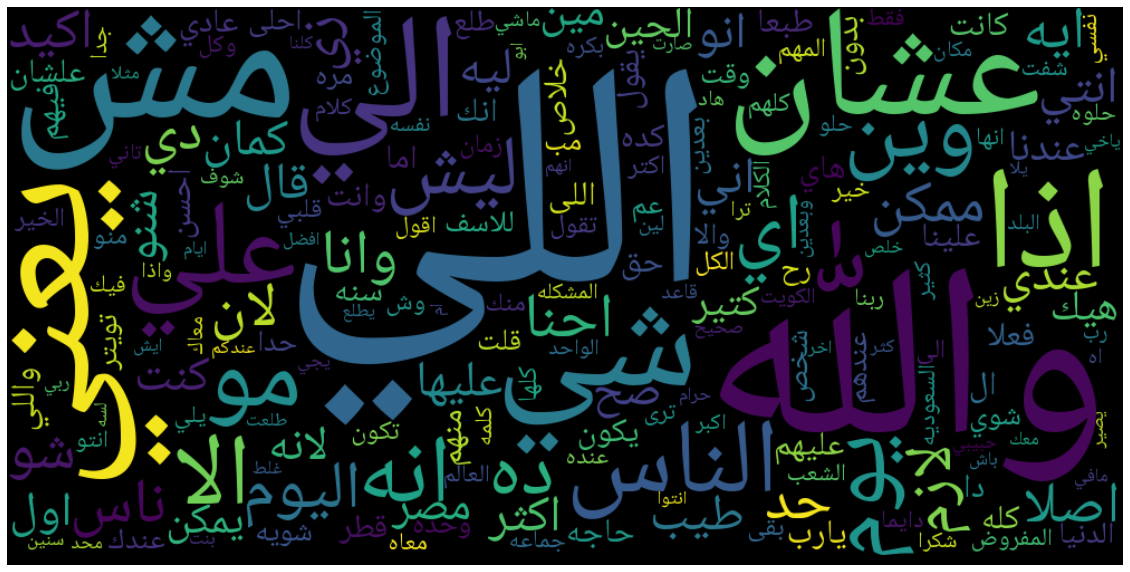

In [75]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

text = dialectdf['no_stopw'].str.cat(sep=' ') # Please change this line
reshaped_text = arabic_reshaper.reshape(text)
bidi_text = get_display(reshaped_text)

font_file = 'NotoNaskhArabic-VF.ttf'
# You can download it from here https://eng.m.fontke.com/font/67285747/download/#google_vignette
stopwords = set(STOPWORDS)
stopwords.update( ['هه','او','وكل','وانت','الا','الى','والله'])
wordcloud = WordCloud(width = 1000, height = 500,min_font_size = 10, font_path=font_file, stopwords=stopwords).generate(bidi_text) 
#wordcloud.to_file("arabic_example13.png")
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [76]:
text_all = dialectdf['no_stopw'].str.cat(sep = ' ').split()

In [77]:
Counter(text_all)

Counter({'بالنهايه': 206,
         'ينتفض': 209,
         'يغير': 299,
         'يعني': 13300,
         'محسوب': 69,
         'البشر': 718,
         'حيونه': 11,
         'وحشيه': 8,
         'وتطلبون': 5,
         'الغرب': 203,
         'يحترمكم': 2,
         'ويؤمن': 2,
         'بدينكم': 2,
         'ولاينعتكم': 1,
         'بالارهاب': 17,
         'مبين': 335,
         'كلامه': 651,
         'خليجي': 165,
         'يسلملي': 77,
         'مرورك': 27,
         'وروحك': 43,
         'الحلوه': 983,
         'وين': 8631,
         'الغيبه': 109,
         'اخ': 504,
         'محمد': 3651,
         'يااخي': 160,
         'الارهابي': 91,
         'اذا': 13485,
         'عراقي': 272,
         'سعودي': 563,
         'فلسطيني': 168,
         'المشكله': 2757,
         'باب': 997,
         'الفرض': 12,
         'وماعنده': 49,
         'رحمه': 450,
         'المساس': 9,
         'بقدسيتك': 1,
         'يرضى': 238,
         'عنك': 1348,
         'خلصت': 619,
         'مشاكل': 670,
         'العرب'

In [78]:
word_counter = Counter(text_all)

In [81]:
word_counter.most_common(200)

[('اللي', 60296),
 ('مش', 31201),
 ('والله', 24903),
 ('شي', 19780),
 ('اذا', 13485),
 ('عشان', 13434),
 ('الناس', 13383),
 ('يعني', 13300),
 ('الي', 12851),
 ('اي', 12613),
 ('علي', 12215),
 ('مو', 11928),
 ('انه', 11221),
 ('ده', 11182),
 ('الا', 10183),
 ('يوم', 9960),
 ('شو', 9815),
 ('وين', 8631),
 ('احنا', 8580),
 ('ليش', 8468),
 ('ايه', 8447),
 ('لازم', 8027),
 ('حد', 7850),
 ('دي', 7425),
 ('ناس', 7412),
 ('وانا', 7081),
 ('مره', 7018),
 ('اليوم', 6839),
 ('ممكن', 6731),
 ('اول', 6649),
 ('حاجه', 6551),
 ('يارب', 6542),
 ('اني', 6527),
 ('كنت', 6448),
 ('ربي', 6394),
 ('انك', 6224),
 ('عم', 6085),
 ('زي', 6044),
 ('مين', 5693),
 ('انو', 5667),
 ('يكون', 5612),
 ('خير', 5592),
 ('صح', 5517),
 ('مصر', 5328),
 ('عندي', 5321),
 ('هيك', 5277),
 ('وانت', 5212),
 ('كده', 5183),
 ('انتي', 5150),
 ('سنه', 5129),
 ('شنو', 5127),
 ('اكثر', 5101),
 ('طيب', 5068),
 ('لان', 4911),
 ('ليه', 4883),
 ('قال', 4821),
 ('جدا', 4774),
 ('ربنا', 4638),
 ('كتير', 4592),
 ('فيك', 4563),
 ('رح', 4497),

In [96]:
word_freq = pd.DataFrame(word_counter.most_common(30), columns=['words', 'count'])
word_freq.sample()

,words,count
20,ايه,8447


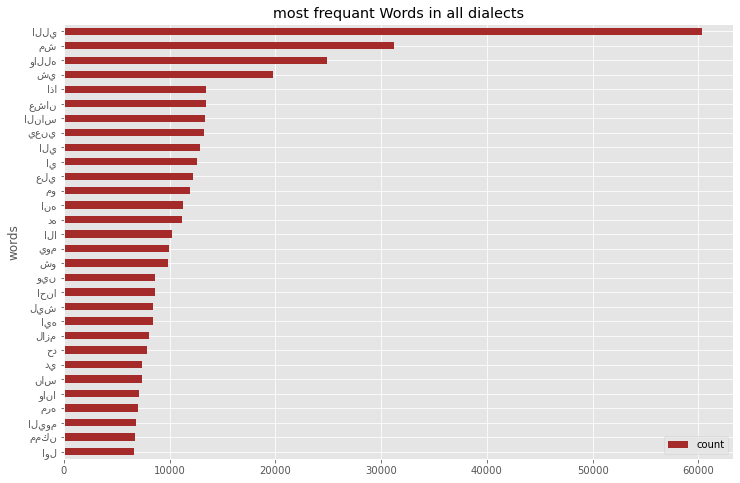

In [118]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color="brown")
ax.set_title("most frequant Words in all dialects")
plt.show()

## Dividing dialects into 4 groups based on the geographical distribution
### Gulf, Levant, Nile Basin and Maghreb (western ar)

In [119]:
dic = {"pl" : 'lev', "jo" : 'lev', "lb" : 'lev', "sy" : 'lev',"iq" : 'gulf', "ae" : 'gulf', "kw" : 'gulf', "ae" : 'gulf',"qa" : 'gulf', "bh" : 'gulf',"om" : 'gulf', "sa" : 'gulf', "ye" : 'gulf', "ly" : 'mor', "dz" : 'mor', "tn" : 'mor',"ma" : 'mor',"eg" : 'nile', "sd" : 'nile'}

In [120]:
dialectdf['grouped'] = dialectdf['dialect'].map(dic)

In [121]:
dialectdf["grouped"].unique()

array(['gulf', 'mor', 'lev', 'nile'], dtype=object)

In [122]:
dialectdf["grouped"].value_counts()

gulf    197095
lev     115478
mor      73424
nile     72010
Name: grouped, dtype: int64

Text(0, 0.5, 'Dialect size in the data')

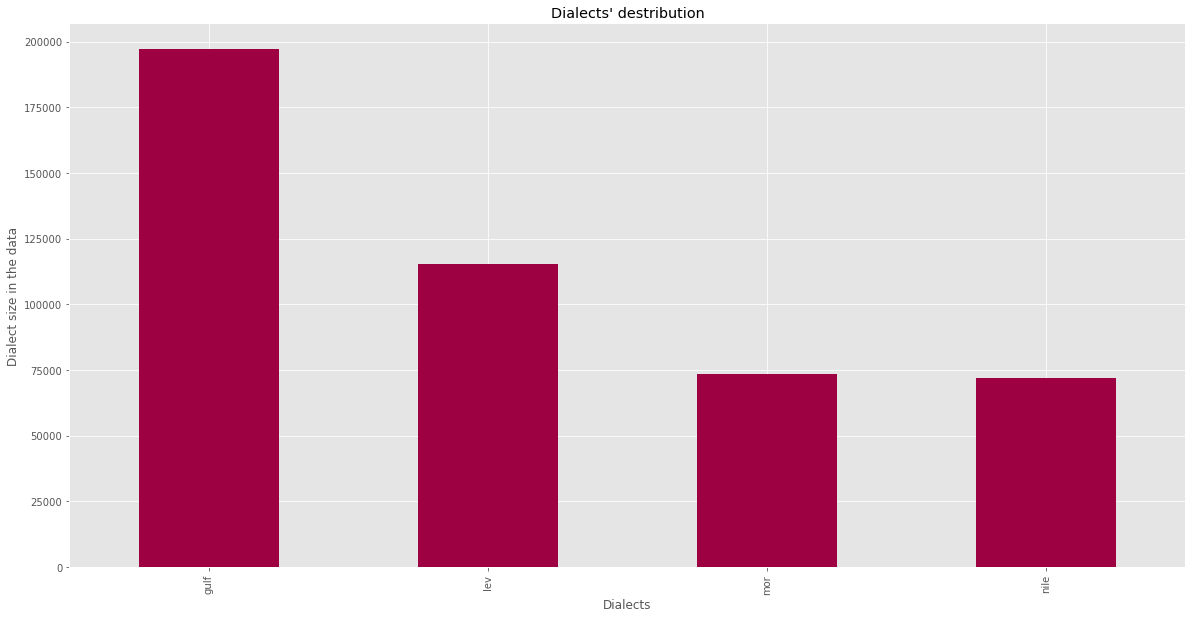

In [125]:
dialectdf["grouped"].value_counts().plot(kind = 'bar', figsize=(20, 10), cmap=cmap, edgecolor='None')
plt.title("Dialects' destribution")
plt.xlabel("Dialects")
plt.ylabel("Dialect size in the data")

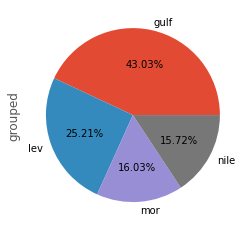

In [124]:
dialectdf["grouped"].value_counts().plot.pie(autopct='%1.2f%%')

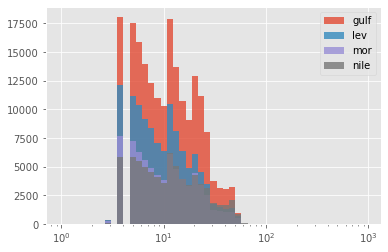

In [130]:
plt.xscale('log')
bins = 1.15**(np.arange(0,50))
plt.hist(dialectdf[dialectdf['grouped']=='gulf']['word_count'],bins=bins,alpha=0.8)
plt.hist(dialectdf[dialectdf['grouped']=='lev']['word_count'],bins=bins,alpha=0.8)
plt.hist(dialectdf[dialectdf['grouped']=='mor']['word_count'],bins=bins,alpha=0.8)
plt.hist(dialectdf[dialectdf['grouped']=='nile']['word_count'],bins=bins,alpha=0.8)


plt.legend(('gulf','lev','mor','nile'))
plt.show()

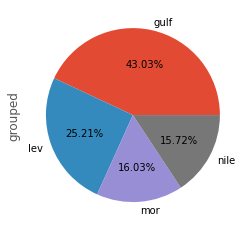

In [132]:
dialectdf['grouped'].value_counts().plot.pie(autopct='%1.2f%%')

In [133]:
gulf = dialectdf[dialectdf['grouped']=='gulf']

In [134]:
text_gulf = gulf['no_stopw'].str.cat(sep = ' ').split()

In [135]:
Counter(text_gulf)

Counter({'بالنهايه': 88,
         'ينتفض': 4,
         'يغير': 161,
         'يعني': 5443,
         'محسوب': 31,
         'البشر': 390,
         'حيونه': 4,
         'وحشيه': 6,
         'وتطلبون': 5,
         'الغرب': 87,
         'يحترمكم': 2,
         'ويؤمن': 2,
         'بدينكم': 1,
         'ولاينعتكم': 1,
         'بالارهاب': 12,
         'مبين': 166,
         'كلامه': 362,
         'خليجي': 111,
         'يسلملي': 10,
         'مرورك': 20,
         'وروحك': 10,
         'الحلوه': 283,
         'وين': 4583,
         'الغيبه': 56,
         'اخ': 227,
         'محمد': 1665,
         'يااخي': 101,
         'الارهابي': 27,
         'اذا': 8267,
         'عراقي': 232,
         'سعودي': 421,
         'فلسطيني': 20,
         'المشكله': 1360,
         'باب': 457,
         'الفرض': 6,
         'وماعنده': 43,
         'رحمه': 235,
         'المساس': 7,
         'بقدسيتك': 1,
         'يرضى': 116,
         'عنك': 664,
         'خلصت': 233,
         'مشاكل': 275,
         'العرب': 657,
    

In [139]:
word_counter_gulf = Counter(text_gulf)

In [140]:
word_counter_gulf.most_common(200)

[('اللي', 30948),
 ('والله', 11718),
 ('شي', 10805),
 ('مو', 9102),
 ('اذا', 8267),
 ('الا', 5935),
 ('الي', 5763),
 ('اي', 5753),
 ('يعني', 5443),
 ('عشان', 5331),
 ('ليش', 5195),
 ('انه', 5170),
 ('يوم', 4925),
 ('الناس', 4901),
 ('وين', 4583),
 ('قطر', 3746),
 ('علي', 3696),
 ('وش', 3452),
 ('الحين', 3410),
 ('اني', 3382),
 ('مب', 3279),
 ('شنو', 3204),
 ('اكثر', 3061),
 ('اليوم', 3034),
 ('وانا', 2990),
 ('مره', 2983),
 ('لازم', 2964),
 ('خير', 2964),
 ('اول', 2864),
 ('انك', 2769),
 ('لان', 2744),
 ('صح', 2737),
 ('حق', 2701),
 ('يقول', 2626),
 ('وانت', 2591),
 ('احنا', 2517),
 ('ربي', 2357),
 ('ناس', 2347),
 ('محد', 2339),
 ('الكويت', 2309),
 ('يارب', 2220),
 ('يكون', 2201),
 ('كنت', 2172),
 ('فيك', 2172),
 ('عليهم', 2165),
 ('عندي', 2155),
 ('بدون', 2149),
 ('ممكن', 2109),
 ('قال', 2101),
 ('عندنا', 2101),
 ('اقول', 2088),
 ('عنده', 2017),
 ('يمكن', 1987),
 ('واللي', 1984),
 ('انتي', 1969),
 ('ترى', 1917),
 ('سنه', 1901),
 ('كله', 1862),
 ('وحده', 1854),
 ('يصير', 1829),
 ('السع

In [173]:
word_freq_gulf = pd.DataFrame(word_counter_gulf.most_common(30), columns=['words', 'count'])
word_freq_gulf.head(10)

,words,count
0,اللي,30948
1,والله,11718
2,شي,10805
3,مو,9102
4,اذا,8267
5,الا,5935
6,الي,5763
7,اي,5753
8,يعني,5443
9,عشان,5331


### Gulf Arabic Dialect word cloud

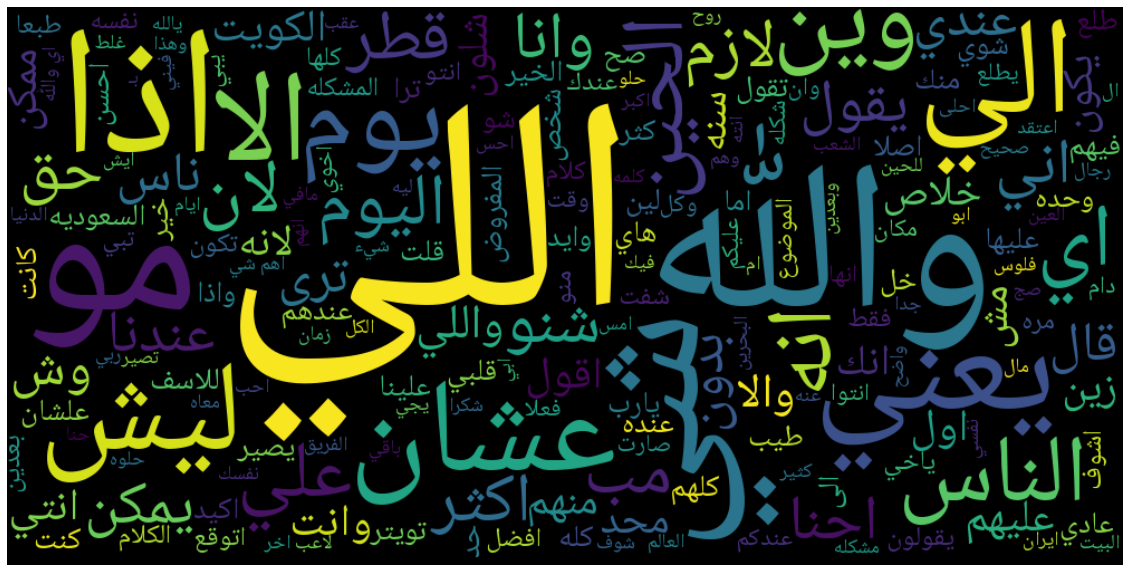

In [138]:
text_gulf2 = gulf['no_stopw'].str.cat(sep=' ') # Please change this line
reshaped_text_gulf = arabic_reshaper.reshape(text_gulf2)
bidi_text_gulf = get_display(reshaped_text_gulf)

font_file = 'NotoNaskhArabic-VF.ttf'
# You can download it from here https://eng.m.fontke.com/font/67285747/download/#google_vignette

wordcloud = WordCloud(width = 1000, height = 500,min_font_size = 10, font_path=font_file,stopwords = ['هه']).generate(bidi_text_gulf) 
wordcloud.to_file("arabic_example13.png")
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

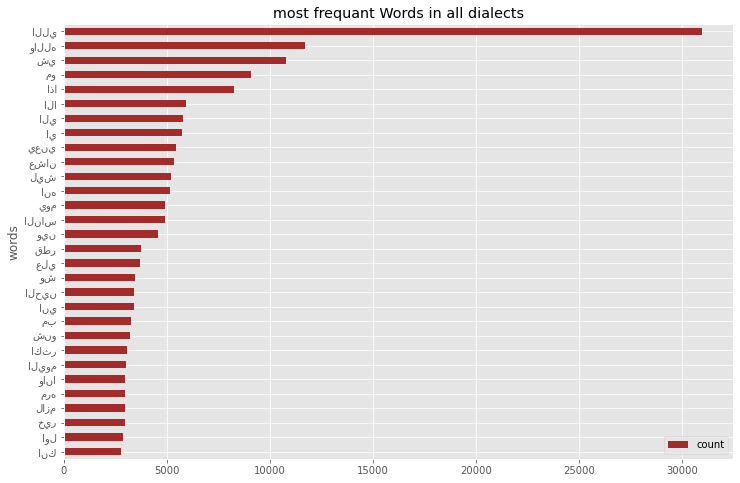

In [143]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq_gulf.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color="brown")
ax.set_title("most frequant Words in all dialects")
plt.show()

#### Levantine Arabic word cloud

In [144]:
lev = dialectdf[dialectdf['grouped']=='lev']

In [145]:
txt_lev = lev['no_stopw'].str.cat(sep = ' ').split()

In [146]:
Counter(txt_lev)

Counter({'جمعتهم': 5,
         'بالصرمايه': 7,
         'عصبن': 2,
         'شارب': 33,
         'عادل': 83,
         'الجبير': 10,
         'سود': 22,
         'وجه': 205,
         'ال': 1168,
         'سعود': 67,
         'زراق': 2,
         'وحوم': 1,
         'كلام': 588,
         'الليل': 260,
         'مدهون': 2,
         'بزبده': 2,
         'وان': 270,
         'طلع': 729,
         'النهار': 63,
         'بسسيح': 1,
         'مين': 3193,
         'الي': 4207,
         'شاغل': 12,
         'بالك': 335,
         'سميرا': 2,
         'صغيره': 150,
         'عبر': 82,
         'منصوره': 2,
         'معلش': 231,
         'اذا': 4101,
         'ممكن': 1716,
         'توضيح': 18,
         'هاد': 1381,
         'الجزئيه': 3,
         'صوره': 439,
         'للخائن': 3,
         'عبدالعزيز': 24,
         'وبيعه': 2,
         'فلسطين': 340,
         'الحفيد': 3,
         'ابو': 1640,
         'منشار': 9,
         'سلف': 26,
         'جده': 53,
         'يسامحه': 16,
         'صاحب': 179,


In [147]:
word_counter_lev = Counter(txt_lev)

In [148]:
word_counter_lev.most_common(200)

[('مش', 11977),
 ('اللي', 10202),
 ('شو', 7549),
 ('والله', 6341),
 ('شي', 5598),
 ('عم', 5269),
 ('هيك', 5072),
 ('انو', 4307),
 ('الي', 4207),
 ('يعني', 4134),
 ('اذا', 4101),
 ('رح', 3886),
 ('حدا', 3386),
 ('انه', 3280),
 ('مين', 3193),
 ('الناس', 3139),
 ('اي', 3053),
 ('عشان', 2995),
 ('كتير', 2795),
 ('ليش', 2690),
 ('لازم', 2606),
 ('كمان', 2442),
 ('يوم', 2419),
 ('اشي', 2323),
 ('يلي', 2306),
 ('وين', 2257),
 ('مو', 2182),
 ('اليوم', 2092),
 ('ناس', 2072),
 ('وانا', 2055),
 ('الا', 2021),
 ('كنت', 1941),
 ('احنا', 1921),
 ('اول', 1891),
 ('مره', 1888),
 ('هاي', 1847),
 ('اكتر', 1816),
 ('بدي', 1772),
 ('رب', 1730),
 ('يكون', 1726),
 ('حد', 1717),
 ('ممكن', 1716),
 ('زي', 1714),
 ('ابو', 1640),
 ('عندي', 1612),
 ('انك', 1611),
 ('طيب', 1600),
 ('اني', 1579),
 ('علي', 1540),
 ('خلص', 1486),
 ('اكيد', 1486),
 ('هيدا', 1440),
 ('يارب', 1439),
 ('احلى', 1383),
 ('هاد', 1381),
 ('انتي', 1375),
 ('معك', 1346),
 ('بدك', 1315),
 ('حلو', 1263),
 ('متل', 1262),
 ('سنه', 1246),
 ('بعرف',

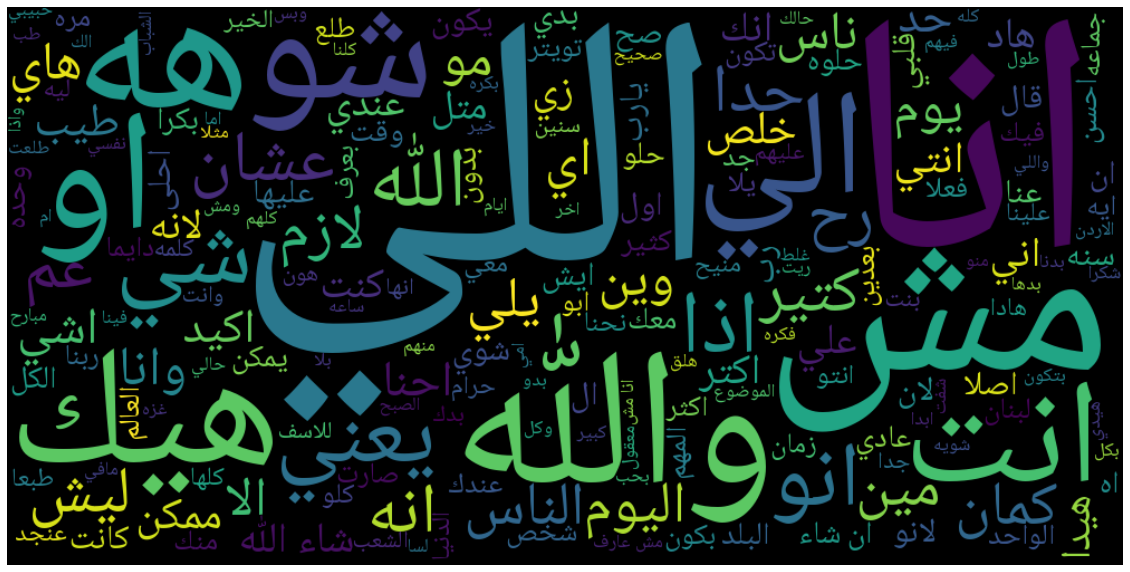

In [58]:
text_lev = lev['no_stopw'].str.cat(sep=' ') # Please change this line
reshaped_text_lev = arabic_reshaper.reshape(text_lev)
bidi_text_lev = get_display(reshaped_text_lev)

font_file = 'NotoNaskhArabic-VF.ttf'
# You can download it from here https://eng.m.fontke.com/font/67285747/download/#google_vignette

wordcloud = WordCloud(width = 1000, height = 500,min_font_size = 10, font_path=font_file).generate(bidi_text_lev) 
wordcloud.to_file("arabic_example13.png")
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [174]:
word_freq_lev = pd.DataFrame(word_counter_lev.most_common(30), columns=['words', 'count'])
word_freq_lev.head(10)

,words,count
0,مش,11977
1,اللي,10202
2,شو,7549
3,والله,6341
4,شي,5598
5,عم,5269
6,هيك,5072
7,انو,4307
8,الي,4207
9,يعني,4134


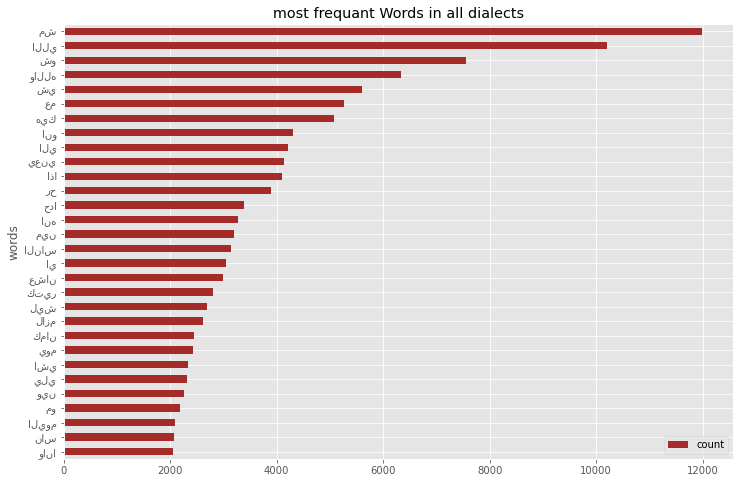

In [150]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq_lev.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color="brown")
ax.set_title("most frequant Words in all dialects")
plt.show()

### Maghrebi Arabic dialect continuum's word cloud

In [151]:
mor = dialectdf[dialectdf['grouped']=='mor']

In [152]:
txt_mor = mor['no_stopw'].str.cat(sep = ' ').split()

In [153]:
Counter(txt_mor)

Counter({'قليلين': 6,
         'ادب': 44,
         'ومنافقين': 1,
         'اختهم': 2,
         'قريبتهم': 1,
         'تتعاكس': 1,
         'تقولي': 148,
         'عليهم': 705,
         'نشاط': 7,
         'حقوق': 51,
         'المراه': 91,
         'رده': 37,
         'فعلهم': 4,
         'الليبين': 201,
         'متقلبين': 1,
         'بالنسبه': 280,
         'ليا': 811,
         'ميليشياوي': 1,
         'زمان': 435,
         'وتوه': 6,
         'تانيه': 122,
         'شاب': 83,
         'ليبي': 221,
         'بيرتاح': 1,
         'لبنت': 22,
         'مختلفه': 22,
         'ويلاحظ': 1,
         'انها': 351,
         'البنات': 218,
         'وبيحس': 1,
         'كانه': 59,
         'يعرفها': 7,
         'بعدين': 231,
         'يتزوج': 35,
         'وحده': 810,
         'منهن': 30,
         'وممكن': 47,
         'ولاثلاثه': 1,
         'وتنقلب': 3,
         'الرومانسيه': 4,
         'لعياط': 1,
         'وشياط': 1,
         'وتهزيب': 1,
         'اند': 5,
         'رانيا': 9,
       

In [154]:
word_counter_mor = Counter(txt_mor)

In [155]:
word_counter_mor.most_common(200)

[('اللي', 8932),
 ('مش', 6175),
 ('والله', 3369),
 ('ربي', 3307),
 ('شي', 2880),
 ('علي', 2628),
 ('الي', 1830),
 ('باش', 1793),
 ('الناس', 1677),
 ('حاجه', 1528),
 ('يعني', 1507),
 ('اي', 1493),
 ('حد', 1428),
 ('يارب', 1395),
 ('زي', 1344),
 ('وين', 1343),
 ('الا', 1317),
 ('شن', 1312),
 ('اليوم', 1261),
 ('ليبيا', 1246),
 ('توا', 1223),
 ('انه', 1215),
 ('مره', 1193),
 ('يوم', 1188),
 ('ناس', 1112),
 ('ممكن', 1067),
 ('اكثر', 1036),
 ('واش', 1022),
 ('راه', 1011),
 ('ايه', 1002),
 ('عندي', 986),
 ('خير', 985),
 ('كنت', 980),
 ('احنا', 976),
 ('لازم', 970),
 ('فيك', 961),
 ('عليها', 930),
 ('ماشي', 907),
 ('اول', 906),
 ('عشان', 889),
 ('وانا', 877),
 ('يكون', 869),
 ('هكي', 858),
 ('تونس', 853),
 ('صح', 850),
 ('اما', 833),
 ('انتي', 812),
 ('ليا', 811),
 ('وحده', 810),
 ('اصلا', 808),
 ('فيهم', 805),
 ('اكيد', 803),
 ('اني', 798),
 ('علاش', 786),
 ('عندك', 777),
 ('عادي', 766),
 ('بالله', 760),
 ('شنو', 756),
 ('اذا', 753),
 ('غازي', 753),
 ('قال', 752),
 ('هاد', 742),
 ('لان', 740

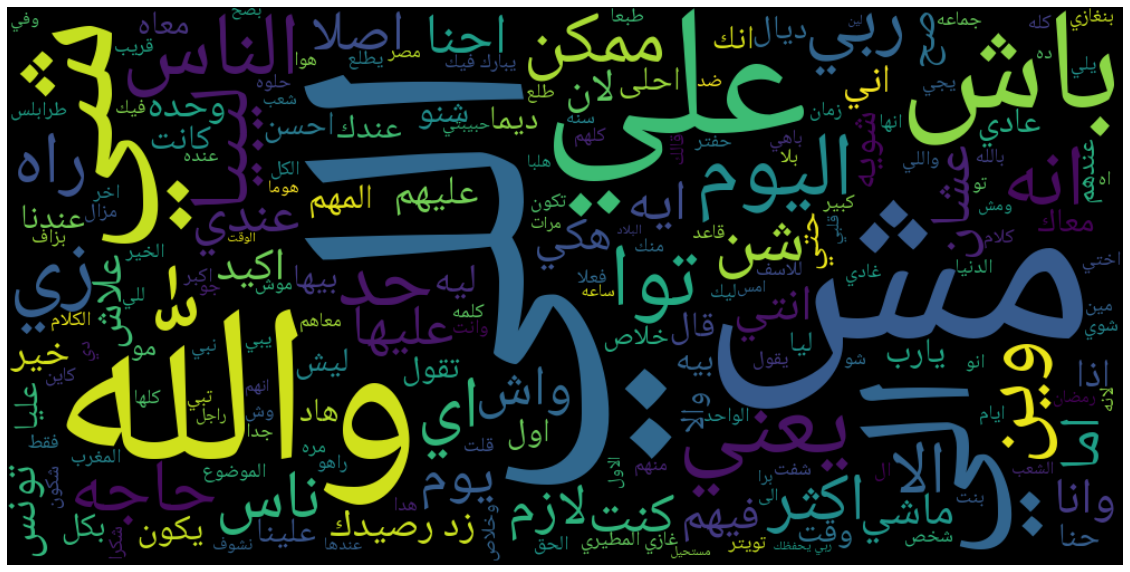

In [156]:
text_mor = mor['no_stopw'].str.cat(sep=' ') # Please change this line
reshaped_text_mor = arabic_reshaper.reshape(text_mor)
bidi_text_mor = get_display(reshaped_text_mor)

font_file = 'NotoNaskhArabic-VF.ttf'
# You can download it from here https://eng.m.fontke.com/font/67285747/download/#google_vignette

wordcloud = WordCloud(width = 1000, height = 500,min_font_size = 10, font_path=font_file).generate(bidi_text_mor) 
wordcloud.to_file("arabic_example13.png")
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [175]:
word_freq_mor = pd.DataFrame(word_counter_mor.most_common(30), columns=['words', 'count'])
word_freq_mor.head(10)

,words,count
0,اللي,8932
1,مش,6175
2,والله,3369
3,ربي,3307
4,شي,2880
5,علي,2628
6,الي,1830
7,باش,1793
8,الناس,1677
9,حاجه,1528


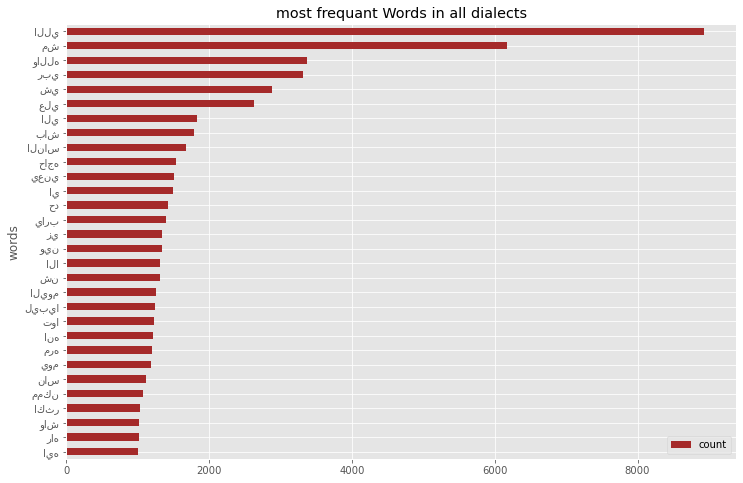

In [158]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq_mor.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color="brown")
ax.set_title("most frequant Words in all dialects")
plt.show()

### Nile basin arabic

In [159]:
nile = dialectdf[dialectdf['grouped']=='nile']

In [160]:
txt_nile = nile['no_stopw'].str.cat(sep = ' ').split()

In [161]:
Counter(txt_nile)

Counter({'الاقيش': 2,
         'معاك': 765,
         'الف': 510,
         'عم': 343,
         'نجيب': 104,
         'قرض': 9,
         'حسن': 195,
         'ابدا': 300,
         'بيهم': 194,
         'حلمي': 17,
         'وهسدهم': 1,
         'شهر': 184,
         'عاوز': 360,
         'تشاركني': 1,
         'هسدهم': 1,
         'بارضو': 1,
         'وتبقى': 29,
         'شريك': 31,
         'بالربع': 2,
         'بتفهم': 52,
         'كنت': 1355,
         'بقيت': 234,
         'زملكاوي': 48,
         'ولولوا': 1,
         'ساعه': 373,
         'وسكتوا': 3,
         'واحده': 732,
         'عشان': 4219,
         'بواب': 16,
         'ملكش': 38,
         'عازه': 5,
         'جنسيتك': 1,
         'ايه': 5649,
         'ده': 10089,
         'صهيوني': 4,
         'مش': 11263,
         'هتقول': 34,
         'كده': 4599,
         'عندنا': 735,
         'مصر': 3796,
         'كانوا': 385,
         'هيعملوا': 25,
         'برضو': 548,
         'ويجيبوا': 7,
         'الاخطاء': 15,
         'اللي

In [162]:
word_counter_nile = Counter(txt_nile)

In [163]:
word_counter_nile.most_common(200)

[('مش', 11263),
 ('اللي', 10214),
 ('ده', 10089),
 ('دي', 6304),
 ('ايه', 5649),
 ('كده', 4599),
 ('علي', 4351),
 ('عشان', 4219),
 ('حاجه', 4014),
 ('اللى', 3797),
 ('مصر', 3796),
 ('الناس', 3666),
 ('والله', 3475),
 ('دا', 3450),
 ('ربنا', 3364),
 ('احنا', 3166),
 ('حد', 2929),
 ('ليه', 2635),
 ('زي', 2492),
 ('اي', 2314),
 ('يعني', 2216),
 ('ناس', 1881),
 ('علشان', 1848),
 ('ممكن', 1839),
 ('دى', 1831),
 ('مين', 1644),
 ('بقى', 1619),
 ('كمان', 1572),
 ('انه', 1556),
 ('جدا', 1523),
 ('يارب', 1488),
 ('لازم', 1487),
 ('كدا', 1443),
 ('يوم', 1428),
 ('اكتر', 1401),
 ('لسه', 1394),
 ('كتير', 1390),
 ('سنه', 1369),
 ('كنت', 1355),
 ('طيب', 1311),
 ('ال', 1300),
 ('تاني', 1291),
 ('شويه', 1272),
 ('عارف', 1269),
 ('دول', 1232),
 ('بقي', 1176),
 ('وانا', 1159),
 ('فعلا', 1155),
 ('انك', 1141),
 ('اصلا', 1127),
 ('شنو', 1114),
 ('الكلام', 1113),
 ('مفيش', 1084),
 ('بجد', 1065),
 ('الي', 1051),
 ('كانت', 1010),
 ('كله', 1004),
 ('وانت', 999),
 ('عايز', 998),
 ('انتي', 994),
 ('اول', 988),
 

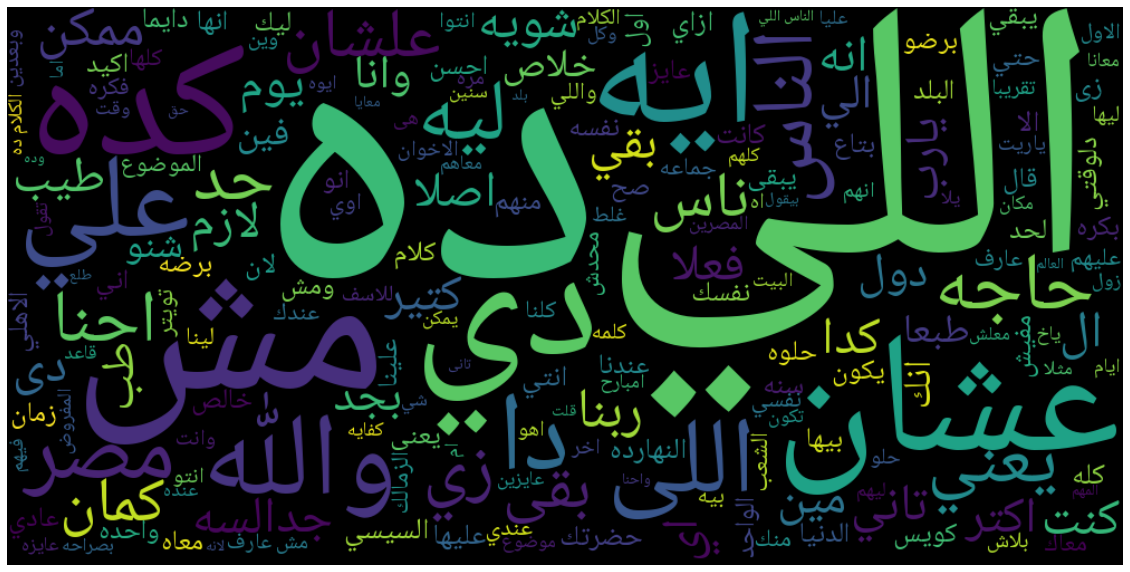

In [164]:
text_nile = nile['no_stopw'].str.cat(sep=' ') # Please change this line
reshaped_text_nile = arabic_reshaper.reshape(text_nile)
bidi_text_nile = get_display(reshaped_text_nile)

font_file = 'NotoNaskhArabic-VF.ttf'
# You can download it from here https://eng.m.fontke.com/font/67285747/download/#google_vignette

wordcloud = WordCloud(width = 1000, height = 500,min_font_size = 10, font_path=font_file).generate(bidi_text_nile) 
wordcloud.to_file("arabic_example13.png")
plt.figure(figsize=(20,15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [176]:
word_freq_nile = pd.DataFrame(word_counter_nile.most_common(30), columns=['words', 'count'])
word_freq_nile.head(10)

,words,count
0,مش,11263
1,اللي,10214
2,ده,10089
3,دي,6304
4,ايه,5649
5,كده,4599
6,علي,4351
7,عشان,4219
8,حاجه,4014
9,اللى,3797


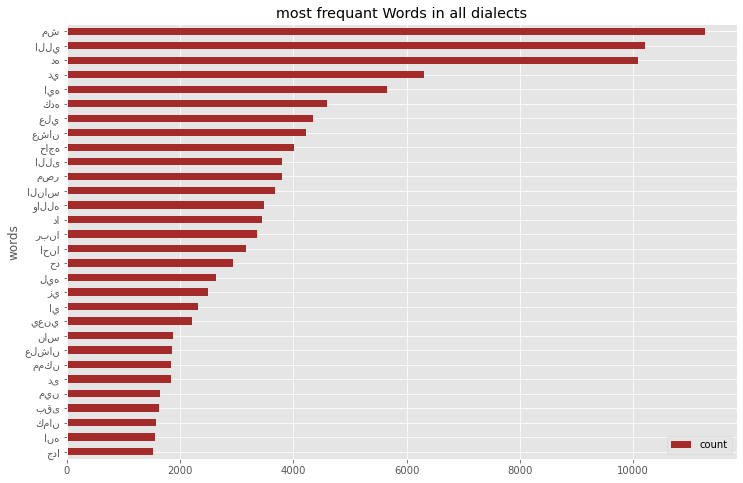

In [177]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq_nile.sort_values(by='count').plot.barh(x='words',y='count',ax=ax, color="brown")
ax.set_title("most frequant Words in all dialects")
plt.show()

## Initialize the spaCy model using AraVec vectors

In [57]:
#!python -m spacy  init vectors ar C:/Users/MLK/nlp/aravec.txt D:\Desktop\NLP\model\01 --name ar_vec_sg

[2022-04-08 05:35:10,289] [INFO] Reading vectors from C:\Users\MLK\nlp\aravec.txt

[i] Creating blank nlp object for language 'ar'
[+] Successfully converted 1476715 vectors
[+] Saved nlp object with vectors to output directory. You can now use the path
to it in your config as the 'vectors' setting in [initialize].
D:\Desktop\NLP\model\01




0it [00:00, ?it/s]
1275it [00:00, 11683.86it/s]
2447it [00:00, 11686.25it/s]
3595it [00:00, 11619.44it/s]
4754it [00:00, 11602.18it/s]
5912it [00:00, 11591.22it/s]
7065it [00:00, 11568.48it/s]
8222it [00:00, 11560.60it/s]
9376it [00:00, 11550.31it/s]
10532it [00:00, 11544.87it/s]
11684it [00:01, 11533.32it/s]
12845it [00:01, 11552.14it/s]
14005it [00:01, 11558.13it/s]
15148it [00:01, 11515.26it/s]
16303it [00:01, 11521.58it/s]
17460it [00:01, 11527.95it/s]
18613it [00:01, 11524.48it/s]
19802it [00:01, 11623.53it/s]
20977it [00:01, 11655.99it/s]
22166it [00:01, 11717.58it/s]
23381it [00:02, 11832.27it/s]
24593it [00:02, 11909.48it/s]
25791it [00:02, 11918.53it/s]
26983it [00:02, 11910.78it/s]
28191it [00:02, 11953.12it/s]
29395it [00:02, 11967.03it/s]
30607it [00:02, 12004.88it/s]
31820it [00:02, 12030.10it/s]
33035it [00:02, 12058.22it/s]
34241it [00:02, 12050.95it/s]
35450it [00:03, 12050.31it/s]
36657it [00:03, 12048.09it/s]
37870it [00:03, 12064.56it/s]
39077it [00:03, 12055.43it/

464078it [00:40, 11116.49it/s]
465268it [00:40, 11129.55it/s]
466390it [00:40, 11148.50it/s]
467510it [00:40, 11159.93it/s]
468637it [00:40, 11188.78it/s]
469760it [00:41, 11193.04it/s]
470938it [00:41, 11356.78it/s]
472089it [00:41, 11390.99it/s]
473250it [00:41, 11448.20it/s]
474429it [00:41, 11542.22it/s]
475636it [00:41, 11684.07it/s]
476815it [00:41, 11708.06it/s]
477997it [00:41, 11731.41it/s]
479171it [00:41, 11728.52it/s]
480345it [00:41, 11725.50it/s]
481518it [00:42, 11714.88it/s]
482690it [00:42, 11709.29it/s]
483862it [00:42, 11707.19it/s]
485033it [00:42, 11697.56it/s]
486203it [00:42, 11690.88it/s]
487373it [00:42, 11681.74it/s]
488570it [00:42, 11759.26it/s]
489764it [00:42, 11805.44it/s]
491076it [00:42, 11813.59it/s]
492360it [00:43, 11776.15it/s]
493637it [00:43, 11731.78it/s]
494921it [00:43, 11719.94it/s]
496191it [00:43, 11672.22it/s]
497404it [00:43, 11475.89it/s]
498693it [00:43, 11552.43it/s]
500008it [00:43, 11676.20it/s]
501330it [00:43, 11781.60it/s]
502587it

### Loading aravec with spacy

In [178]:
nlp = spacy.load("D:/Desktop/NLP/model/01")

In [185]:
# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    text = text.replace('هه','')
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [186]:
# Define the preprocessing Class
class Preprocessor:
    def __init__(self, tokenizer, **cfg):
        self.tokenizer = tokenizer

    def __call__(self, text):
        preprocessed = clean_str(text)
        return self.tokenizer(preprocessed)

In [187]:
# Apply the `Preprocessor` Class
nlp.tokenizer = Preprocessor(nlp.tokenizer)

#### Getting vectors from our data using aravec word2vec model

In [188]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [189]:
dialectdf['vec'] = dialectdf['clean_tweet'].apply(lambda x: get_vec(x))

In [190]:
dialectdf.sample(2)

,dialect,clean_tweet,no_stopw,char_count,word_count,nostop_count,grouped,vec
178953,jo,حد عنده الرساله يلي بترسلها ل اشخاص و بتسمع خبر حلو لاني متبهدله شويه هاليومين,حد عنده الرساله يلي بترسلها اشخاص بتسمع خبر حلو لاني متبهدله شويه هاليومين,64,15,13,lev,"[0.10723935, -0.13626614, 0.07651163, 0.13653934, -0.10246683, -0.057444546, 0.14098622, 0.19286086, 0.08078159, 0.054723345, -0.04879045, -0.053117223, 0.108100265, 0.0649748, 0.07028277, -0.030555893, 0.07087862, 0.0242856, -0.043529123, -0.11959847, -0.014174761, -0.08782629, -0.08225621, 0.005492, -0.058397815, -0.13512482, 0.0732453, 0.06601616, 0.0013184361, -0.008209327, -0.009176327, -0.1222737, -0.080711365, -0.004242396, -0.20267649, 0.039097864, -0.056497257, 0.058717456, 0.20584118, -0.01563852, -0.09815151, 0.103723794, -0.026557054, 0.13914485, -0.22241724, -0.030554382, 0.2003727, 0.11557945, 0.24535185, -0.045597196, -0.17812167, -0.019011572, 0.048436947, 0.09343892, 0.12372467, 0.01698588, 0.039330177, 0.11038273, 0.039190926, 0.16323887, -0.0016740945, 0.009582292, 0.02623324, -0.015462261, -0.051407848, -0.03282465, 0.018985981, 0.11874182, 0.12349252, 0.12039449, -0.020803995, -0.10373769, 0.012256963, -0.027012356, 0.030290361, -0.027681328, 0.11063248, 0.1217..."
300550,eg,عملت زي عاطف و اللمبي راحت تحشر مناخيرها في حديث بين ترودو بتاع كندا و كريستين لاجارد بتاعه صندوق النقد,عملت زي عاطف اللمبي راحت تحشر مناخيرها حديث ترودو بتاع كندا كريستين لاجارد بتاعه صندوق النقد,84,20,16,nile,"[0.013656946, -0.034757614, 0.10751007, 0.043340586, -0.050909784, -0.04244402, 0.08887377, 0.10829586, 0.109167755, 0.14310467, -0.04612446, 0.00929101, 0.06630302, -0.047805, -0.015696649, 0.023900509, -0.050355352, 0.023520099, -0.1027412, -0.047539093, -0.005164823, -0.0068146004, -0.08735541, -0.005728546, 0.014481879, -0.10451049, 0.12039634, 0.023466112, 0.030775016, 0.071034744, -0.3028947, 0.073569424, -0.05664411, -0.08690824, -0.32904962, 0.23086995, -0.07961274, -0.007085171, 0.19810694, -0.017645247, -0.100052066, 0.085765116, -0.1252927, 0.13956328, -0.3736962, 0.0364267, 0.019453526, 0.24918918, 0.29166746, -0.05114912, -0.23857579, -0.0737789, -0.066162325, 0.057506617, 0.077449895, 0.04379481, -0.078322165, 0.108244546, -0.05821624, 0.24971528, 0.11572838, 0.021315748, 0.14406668, -0.04916805, 0.007704941, -0.09088709, -0.09523861, 0.09733358, -0.00036546588, -0.06201181, 0.15601651, 0.061723433, -0.0062909923, -0.1057618, 0.021946706, -0.0385913, -0.15122235, 0.16..."


In [191]:
dialectdf.shape

(458007, 8)

In [192]:
X = dialectdf['vec'].to_numpy()
X  = X.reshape(-1, 1)

In [193]:
X.shape

(458007, 1)

In [194]:
X = np.concatenate(np.concatenate(X, axis = 0), axis = 0).reshape(-1, 300)

In [195]:
X.shape

(458007, 300)

In [196]:
y = dialectdf['grouped']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [198]:
X_train.shape, X_test.shape

((366405, 300), (91602, 300))

## LogisticRegression model

In [199]:
clf = LogisticRegression(solver = 'liblinear', class_weight = 'balanced')

In [200]:
clf.fit(X_train, y_train) #2min

LogisticRegression(class_weight='balanced', solver='liblinear')

In [201]:
y_pred = clf.predict(X_test)

In [202]:
confusion_matrix(y_test, y_pred)

array([[34269,  2257,  1739,  1154],
       [ 3502, 16507,  1239,  1848],
       [ 2495,  1333,  9473,  1384],
       [  887,   994,   734, 11787]], dtype=int64)

In [203]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7864020436235016


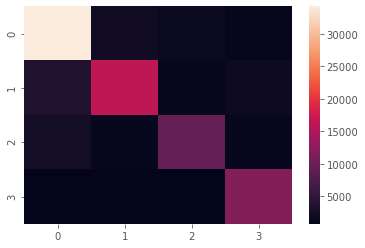

In [204]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [205]:
print(classification_report(X_test,y_pred))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multiclass targets

In [206]:
y_pred

array(['gulf', 'gulf', 'gulf', ..., 'nile', 'gulf', 'gulf'], dtype=object)

In [207]:
y_test

380416    gulf
399146    nile
29241      mor
16762      mor
34551      mor
          ... 
409353    gulf
100091     lev
83945      lev
428281    gulf
422559    gulf
Name: grouped, Length: 91602, dtype: object

In [208]:
lr_model = LogisticRegression(solver='lbfgs')

lr_model.fit(X_train, y_train)

C:\Users\MLK\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [209]:
y_pred = lr_model.predict(X_test)

In [210]:
confusion_matrix(y_test, y_pred)

array([[35772,  1894,   959,   794],
       [ 4364, 16476,   808,  1448],
       [ 3314,  1441,  8808,  1122],
       [ 1346,  1288,   591, 11177]], dtype=int64)

In [211]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7885526516888277


### LinearSVC modle

In [212]:
clf3 = LinearSVC()
clf3.fit(X_test,y_pred)

LinearSVC()

In [213]:
y_pred = clf3.predict(X_test)

In [214]:
confusion_matrix(y_test, y_pred)

array([[36124,  1744,   781,   770],
       [ 4608, 16333,   683,  1472],
       [ 3609,  1462,  8424,  1190],
       [ 1471,  1209,   469, 11253]], dtype=int64)

In [215]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7874718892600598


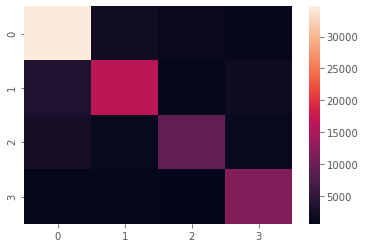

In [93]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [236]:
clf4 = LinearSVC(C = 2500, max_iter=100, class_weight = 'balanced')# 42% 
clf4.fit(X_train,y_train)#1:28

C:\Users\MLK\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=2500, class_weight='balanced', max_iter=100)

In [237]:
clf4.fit(X_train, y_train) #  1.30h start 11:30 --- 10m

C:\Users\MLK\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=2500, class_weight='balanced', max_iter=100)

In [238]:
y_pred = clf4.predict(X_test)

In [239]:
y_pred = clf4.predict(X_test)

In [240]:
confusion_matrix(y_test, y_pred)

array([[36513,  1044,  1310,   552],
       [ 7183, 13071,  1602,  1240],
       [ 4894,   898,  8066,   827],
       [ 3372,  1130,  1205,  8695]], dtype=int64)

In [ ]:
#print(classification_report(y_test, y_pred))

In [241]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7242745791576604


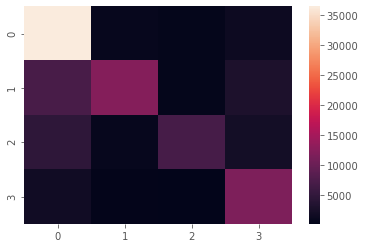

In [100]:
sns.heatmap(confusion_matrix(y_test, y_pred))

##  RandomForestClassifier Model

In [242]:
clf5 = RandomForestClassifier(n_estimators = 1000)

In [243]:
clf5.fit(X_train, y_train) # 4 h---  start 6:05 

RandomForestClassifier(n_estimators=1000)

In [244]:
y_pred = clf5.predict(X_test)

In [245]:
confusion_matrix(y_test,y_pred)

array([[37863,  1105,    87,   364],
       [ 7986, 13963,    81,  1066],
       [ 6844,  1806,  5095,   940],
       [ 2929,  1862,   136,  9475]], dtype=int64)

In [246]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.724831335560359


### svm

In [247]:
clf6 = SVC(gamma = 'auto')

In [ ]:
clf6.fit(X_train,y_train)

In [ ]:
y_pred = clf6.predict(X_test)

In [ ]:
confusion_matrix(y_test,y_pred)

## DecisionTreeClassifier

In [ ]:
clf7 = DecisionTreeClassifier(class_weight = 'balanced')

In [ ]:
clf7.fit(X_train,y_train)

In [ ]:
y_pred = clf6.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

### Working on Dialects 

In [ ]:
dialectdf['vec'] = dialectdf['clean_tweet'].apply(lambda x: get_vec(x))

In [ ]:
y = dialectdf['dialect']

### TfIdf

In [ ]:
tfidf = TfidfVectorizer(max_features= 4000,ngram_range= (1,2), analyzer='word', norm='l1')
X = tfidf.fit_transform(balanced['clean_tweet'])
y = balanced['dialect'] # lable encode ---> le = preprocessing.LabelEncoder()

### BoW

In [ ]:
cv2 = CountVectorizer(ngram_range= (1,3), binary = False) #max_features
count2 = cv2.fit(X_train)

In [ ]:
count.toarray()
print(cv.get_feature_names())

In [ ]:
len(cv2.get_feature_names())

In [ ]:
X_train_cv = cv2.transform(X_train)
X_test_cv = cv2.transform(X_test)

In [ ]:
X_train_cv

In [ ]:
X_df = pd.DataFrame(X_train_cv.toarray(), columns = cv2.get_feature_names())
print(X_df.head())